In [134]:
from shapely.geometry import Point
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic, lonlat
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Crime data (2010-2019): https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
<br>Crime data (2020-2023): https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8

Zipcode geojson file: https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/ca_california_zip_codes_geo.min.json

In [135]:
file_path = '/Users/yokij/Desktop/Capstone/LA'
df_old = pd.read_csv(file_path + '/LA_2010_to_2019.csv', low_memory = False)
df_new = pd.read_csv(file_path + '/LA_2020_to_Present.csv', low_memory = False)

In [136]:
df = pd.concat([df_old, df_new], ignore_index=True)
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(' ', '_')
df['date_occ'] = df['date_occ'].str.slice(0, 10)
df['date_occ'] = pd.to_datetime(df['date_occ'], format='%m/%d/%Y')
df['date_occ'] = df['date_occ'].dt.strftime('%Y-%m-%d')
df.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area
0,1307355,02/20/2010 12:00:00 AM,2010-02-20,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,09/13/2010 12:00:00 AM,2010-09-12,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,08/09/2010 12:00:00 AM,2010-08-09,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,01/05/2010 12:00:00 AM,2010-01-05,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,01/03/2010 12:00:00 AM,2010-01-02,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [137]:
# Filtering dates
df['date_occ'] = pd.to_datetime(df['date_occ'])
threshold_date_from = pd.to_datetime('2018-01-01')
threshold_date_to = pd.to_datetime('2023-05-31')
df = df[threshold_date_to >= df['date_occ']]
df = df[threshold_date_from <= df['date_occ']]
df.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area
1609585,180115381,06/04/2018 12:00:00 AM,2018-06-04,1540,1.0,Central,163,1,648,ARSON,...,Invest Cont,648.0,NaN,NaN,NaN,7TH,SPRING,34.0445,-118.2523,NaN
1610871,180225137,12/25/2018 12:00:00 AM,2018-12-24,1100,2.0,Rampart,236,1,510,VEHICLE - STOLEN,...,Adult Other,510.0,NaN,NaN,NaN,ALVARADO,MIRAMAR,34.0639,-118.2721,NaN
1611007,181314604,06/29/2018 12:00:00 AM,2018-06-26,1200,13.0,Newton,1363,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,1000 E 51ST ST,NaN,33.9966,-118.2582,NaN
1611402,180322696,10/07/2018 12:00:00 AM,2018-10-06,1100,3.0,Southwest,398,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,600 W VERNON AV,NaN,34.0074,-118.2850,NaN
1611684,181911558,05/25/2018 12:00:00 AM,2018-05-24,400,19.0,Mission,1917,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,14200 POLK ST,NaN,34.3139,-118.4427,NaN


In [138]:
df['location'] = df.apply(lambda row: f"({row['lat']}, {row['lon']})", axis=1)

In [139]:
file_path_geo = '/Users/yokij/Desktop/Capstone/LA/ca_california_zip_codes_geo.min.json'
zipcode = gpd.read_file(file_path_geo)
zipcode.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,06,94601,0694601,B5,G6350,S,8410939,310703,+37.7755447,-122.2187049,N,"POLYGON ((-122.22717 37.79197, -122.22693 37.7..."
1,06,94501,0694501,B5,G6350,S,20539466,9005303,+37.7737968,-122.2781230,N,"POLYGON ((-122.29181 37.76301, -122.30661 37.7..."
2,06,94560,0694560,B5,G6350,S,35757865,60530,+37.5041413,-122.0323587,N,"POLYGON ((-122.05499 37.54959, -122.05441 37.5..."
3,06,94587,0694587,B5,G6350,S,51075108,0,+37.6031556,-122.0186382,N,"POLYGON ((-122.06515 37.60485, -122.06499 37.6..."
4,06,94580,0694580,B5,G6350,S,8929836,17052,+37.6757312,-122.1330170,N,"POLYGON ((-122.12999 37.68445, -122.12995 37.6..."


In [140]:
def create_point_from_string(coord_str):
    match = re.match(r'\(([^,]+), ([^)]+)\)', coord_str)
    if match:
        lat, lon = map(float, match.groups())
        return Point(lon, lat)
    return None

In [141]:
df['geometry'] = df['location'].apply(create_point_from_string)

In [142]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area,geometry
1609585,180115381,06/04/2018 12:00:00 AM,2018-06-04,1540,1.0,Central,163,1,648,ARSON,...,648.0,NaN,NaN,NaN,"(34.0445, -118.2523)",SPRING,34.0445,-118.2523,NaN,POINT (-118.25230 34.04450)
1610871,180225137,12/25/2018 12:00:00 AM,2018-12-24,1100,2.0,Rampart,236,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0639, -118.2721)",MIRAMAR,34.0639,-118.2721,NaN,POINT (-118.27210 34.06390)
1611007,181314604,06/29/2018 12:00:00 AM,2018-06-26,1200,13.0,Newton,1363,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(33.9966, -118.2582)",NaN,33.9966,-118.2582,NaN,POINT (-118.25820 33.99660)
1611402,180322696,10/07/2018 12:00:00 AM,2018-10-06,1100,3.0,Southwest,398,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0074, -118.285)",NaN,34.0074,-118.2850,NaN,POINT (-118.28500 34.00740)
1611684,181911558,05/25/2018 12:00:00 AM,2018-05-24,400,19.0,Mission,1917,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.3139, -118.4427)",NaN,34.3139,-118.4427,NaN,POINT (-118.44270 34.31390)


In [143]:
gdf.set_crs(epsg=4326, inplace=True)
zipcode.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, zipcode, how="left", op='within')

/Users/yokij/opt/anaconda3/lib/python3.9/site-packages/geopandas/sindex.py:87: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, item) in enumerate(geometry.iteritems())


In [144]:
result.set_index('date_occ', inplace=True)

In [145]:
result.index = pd.to_datetime(result.index)
result.head()

,dr_no,date_rptd,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
date_occ,,,,,,,,,,,,,,,,,,,,,
2018-06-04,180115381,06/04/2018 12:00:00 AM,1540,1.0,Central,163,1,648,ARSON,0329 2004,...,90014,0690014,B5,G6350,S,733437.0,0.0,+34.0431457,-118.2517464,N
2018-12-24,180225137,12/25/2018 12:00:00 AM,1100,2.0,Rampart,236,1,510,VEHICLE - STOLEN,NaN,...,90057,0690057,B5,G6350,S,2293706.0,34211.0,+34.0617348,-118.2767572,N
2018-06-26,181314604,06/29/2018 12:00:00 AM,1200,13.0,Newton,1363,1,510,VEHICLE - STOLEN,NaN,...,90011,0690011,B5,G6350,S,11100424.0,529.0,+34.0070900,-118.2586805,N
2018-10-06,180322696,10/07/2018 12:00:00 AM,1100,3.0,Southwest,398,1,510,VEHICLE - STOLEN,NaN,...,90037,0690037,B5,G6350,S,7351184.0,0.0,+34.0027226,-118.2874866,N
2018-05-24,181911558,05/25/2018 12:00:00 AM,400,19.0,Mission,1917,1,510,VEHICLE - STOLEN,NaN,...,91342,0691342,B5,G6350,S,142711370.0,710812.0,+34.3266744,-118.3822622,N


In [146]:
weekly_data = result.groupby('ZCTA5CE10').resample('W').size().reset_index(name='total_count')

In [147]:
weekly_data['ZCTA5CE10'].unique().shape

(151,)

In [148]:
weekly_data

,ZCTA5CE10,date_occ,total_count
0,90001,2018-01-07,21
1,90001,2018-01-14,14
2,90001,2018-01-21,17
3,90001,2018-01-28,16
4,90001,2018-02-04,23
...,...,...,...
40084,91801,2021-04-18,0
40085,91801,2021-04-25,0
40086,91801,2021-05-02,0
40087,91801,2021-05-09,1


In [149]:
weekly_data.to_csv('la_weekly.csv')

In [150]:
mean_counts_by_zip = weekly_data.groupby('ZCTA5CE10')['total_count'].mean().reset_index()
mean_counts_by_zip

,ZCTA5CE10,total_count
0,90001,17.014134
1,90002,46.466431
2,90003,107.445230
3,90004,65.286219
4,90005,43.307420
...,...,...
146,91606,38.254417
147,91607,23.699647
148,91608,0.620567
149,91801,0.086207


# Population

ACS2022 https://data.census.gov/table/ACSDP5Y2022.DP05?g=050XX00US06037$8600000

In [151]:
pop = pd.read_csv('/Users/yokij/Desktop/Capstone/LA/LA_ACSDP5Y2022DP05.csv', low_memory = False)
pop.head()

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0002E,DP05_0002M,DP05_0003E,DP05_0003M,DP05_0004E,DP05_0004M,...,DP05_0087PM,DP05_0088PE,DP05_0088PM,DP05_0089PE,DP05_0089PM,DP05_0090PE,DP05_0090PM,DP05_0091PE,DP05_0091PM,Unnamed: 366
0,Geography,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population...,Estimate!!SEX AND AGE!!Total population!!Female,Margin of Error!!SEX AND AGE!!Total population...,Estimate!!SEX AND AGE!!Total population!!Sex r...,Margin of Error!!SEX AND AGE!!Total population...,...,Percent Margin of Error!!HISPANIC OR LATINO AN...,Percent!!Total housing units,Percent Margin of Error!!Total housing units,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...",NaN
1,860Z200US90001,ZCTA5 90001,57652,2615,29102,1541,28550,1636,101.9,6.4,...,0.3,(X),(X),25411,(X),50.2,2.4,49.8,2.4,NaN
2,860Z200US90002,ZCTA5 90002,53108,2472,26040,1537,27068,1300,96.2,5.1,...,0.2,(X),(X),25979,(X),46.1,2.1,53.9,2.1,NaN
3,860Z200US90003,ZCTA5 90003,75024,3354,37793,2061,37231,1702,101.5,4.7,...,0.1,(X),(X),31241,(X),45.5,1.9,54.5,1.9,NaN
4,860Z200US90004,ZCTA5 90004,58833,2270,29865,1410,28968,1330,103.1,5.4,...,0.7,(X),(X),33010,(X),50.6,1.8,49.4,1.8,NaN


In [152]:
pop = pop[['NAME', 'DP05_0001E']]
pop = pop.rename(columns={"NAME": "ZCTA5CE10"})
pop = pop.rename(columns={"DP05_0001E": "total_population"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.drop(0)
pop.head()

,ZCTA5CE10,total_population
1,90001,57652
2,90002,53108
3,90003,75024
4,90004,58833
5,90005,37754


In [153]:
pop['total_population'] = pd.to_numeric(pop['total_population'], errors='coerce')
total_population_sum = pop['total_population'].sum()
total_population_sum

10286146

In [154]:
weekly_data['ZCTA5CE10'] = weekly_data['ZCTA5CE10'].astype(str).str.zfill(5)

In [155]:
merged_df = pd.merge(weekly_data, pop, on='ZCTA5CE10', how='left')
merged_df.head()

,ZCTA5CE10,date_occ,total_count,total_population
0,90001,2018-01-07,21,57652.0
1,90001,2018-01-14,14,57652.0
2,90001,2018-01-21,17,57652.0
3,90001,2018-01-28,16,57652.0
4,90001,2018-02-04,23,57652.0


In [156]:
print(merged_df['total_population'].dtype)

float64


In [157]:
merged_df.shape

(40089, 4)

In [158]:
merged_df[merged_df['total_population'] != 0]['ZCTA5CE10'].unique()
merged_df.shape

(40089, 4)

In [159]:
merged_df['total_population'] = merged_df['total_population'].astype(str)

In [160]:
merged_df['total_population'] = pd.to_numeric(merged_df['total_population'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
merged_df['crime_rate'] = (merged_df['total_count'] / merged_df['total_population']) * 10000
merged_df = merged_df.rename(columns={'date_occ': 'week'})
merged_df['week'] = pd.to_datetime(merged_df['week'])

In [117]:
merged_df.tail()

,ZCTA5CE10,week,total_count,total_population,crime_rate
40084,91801,2021-04-18,0,53320,0.000000
40085,91801,2021-04-25,0,53320,0.000000
40086,91801,2021-05-02,0,53320,0.000000
40087,91801,2021-05-09,1,53320,0.187547
40088,91803,2018-07-15,1,29006,0.344756


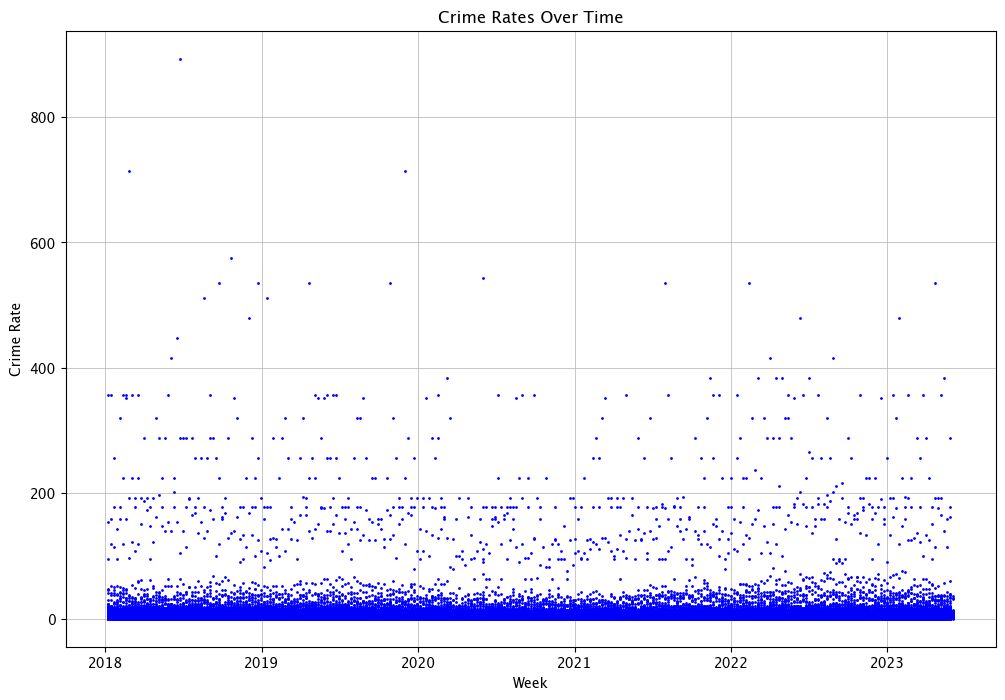

In [107]:
df_plot = merged_df
df_plot.set_index('week', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

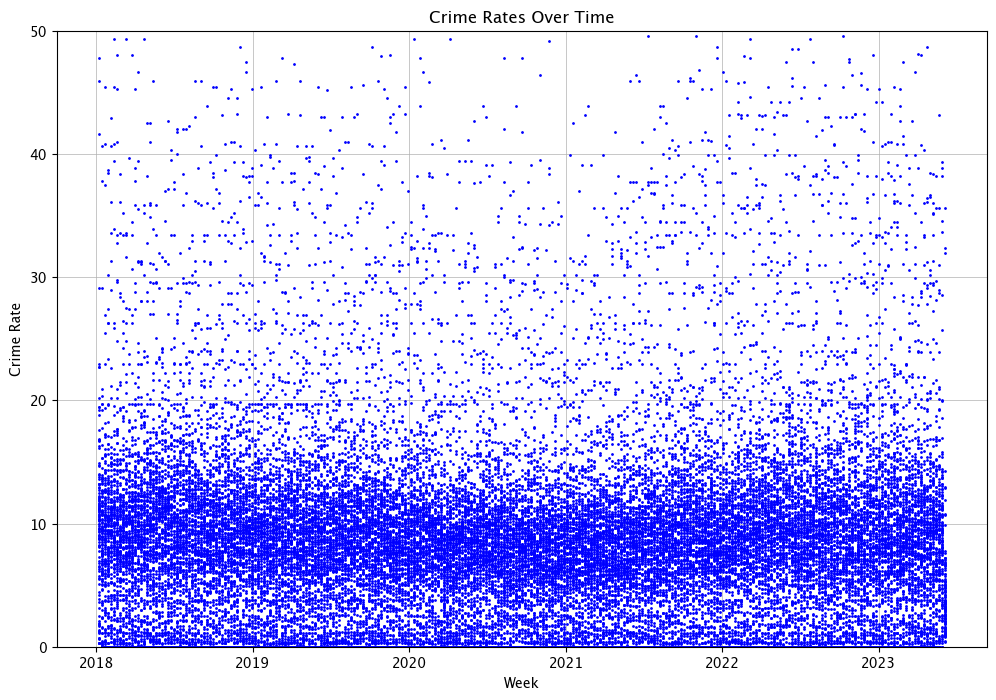

In [34]:
#zoom in
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 50)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [35]:
statistics = merged_df.describe().T
print(statistics)

                    count          mean           std   min           25%  \
total_count       39119.0     30.259414     26.866367   0.0      6.000000   
total_population  39119.0  35924.003937  20694.066196  56.0  22078.000000   
crime_rate        39119.0     11.770289     28.337576   0.0      3.287401   

                           50%           75%            max  
total_count          27.000000     47.000000     189.000000  
total_population  32965.000000  47682.000000  106042.000000  
crime_rate            7.934934     11.478421     892.857143  


In [36]:
merged_df['ZCTA5CE10'].nunique()

147

In [37]:
print(merged_df['total_count'].median())
print(merged_df['total_population'].median())
print(merged_df['crime_rate'].median())

27.0
32965.0
7.934933544931561


# S2301 Employment

ACS2018 https://data.census.gov/table/ACSST5Y2018.S2301?g=050XX00US06037$8600000

In [54]:
crime = merged_df.reset_index()
crime.tail()

,week,ZCTA5CE10,total_count,total_population,crime_rate
39114,2021-04-18,91801,0,53320,0.000000
39115,2021-04-25,91801,0,53320,0.000000
39116,2021-05-02,91801,0,53320,0.000000
39117,2021-05-09,91801,1,53320,0.187547
39118,2018-07-15,91803,1,29006,0.344756


In [55]:
file_path = '/Users/yokij/Desktop/Capstone/LA/LA_ACSST5Y2018S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
employment = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
employment = employment.iloc[1:].reset_index(drop=True)
employment.columns = ['ZCTA5CE10', 'e/pop_rate', 'un_rate']
employment['ZCTA5CE10'] = employment['ZCTA5CE10'].str.replace('ZCTA5 ', '')
employment.head()

,ZCTA5CE10,e/pop_rate,un_rate
0,90001,56.1,9.7
1,90002,51.9,10.3
2,90003,55.2,10.5
3,90004,66.7,4.8
4,90005,65.5,7.2


In [56]:
crime = crime.merge(employment, on = 'ZCTA5CE10', how = 'right')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7


# S1701 poverty

https://data.census.gov/table/ACSST5Y2018.S1701?g=050XX00US06037$8600000

In [57]:
file_path = '/Users/yokij/Desktop/Capstone/LA/LA_ACSST5Y2018S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
poverty = df[['NAME', 'S1701_C03_001E']]
poverty = poverty.iloc[1:].reset_index(drop=True)
poverty.columns = ['ZCTA5CE10', 'p_rate']
poverty['ZCTA5CE10'] = poverty['ZCTA5CE10'].str.replace('ZCTA5 ', '')
poverty.head()

,ZCTA5CE10,p_rate
0,90001,28.8
1,90002,32.9
2,90003,30.7
3,90004,18.1
4,90005,28.1


In [58]:
crime = crime.merge(poverty, on = 'ZCTA5CE10', how = 'outer')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7,28.8
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7,28.8
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7,28.8
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7,28.8
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7,28.8


# S1901 Household Income

https://data.census.gov/table/ACSST5Y2018.S1901?g=050XX00US06037$8600000

In [59]:
file_path = '/Users/yokij/Desktop/Capstone/LA/LA_ACSST5Y2018S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
HI = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
HI = HI.iloc[1:].reset_index(drop=True)
HI.columns = ['ZCTA5CE10', 'in_median', 'in_mean']
HI['ZCTA5CE10'] = HI['ZCTA5CE10'].str.replace('ZCTA5 ', '')
HI.head()

,ZCTA5CE10,in_median,in_mean
0,90001,38521,49526
1,90002,35410,46741
2,90003,37226,47313
3,90004,48754,82746
4,90005,35149,51847


In [60]:
crime = crime.merge(HI, on = 'ZCTA5CE10', how = 'outer')
crime.head(115)

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7,28.8,38521,49526
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7,28.8,38521,49526
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7,28.8,38521,49526
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7,28.8,38521,49526
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7,28.8,38521,49526
...,...,...,...,...,...,...,...,...,...,...
110,2020-02-16,90001,15.0,57652.0,2.601818,56.1,9.7,28.8,38521,49526
111,2020-02-23,90001,16.0,57652.0,2.775272,56.1,9.7,28.8,38521,49526
112,2020-03-01,90001,11.0,57652.0,1.908000,56.1,9.7,28.8,38521,49526
113,2020-03-08,90001,12.0,57652.0,2.081454,56.1,9.7,28.8,38521,49526


# Covid

http://dashboard.publichealth.lacounty.gov/covid19_surveillance_dashboard/
https://www.laalmanac.com/health/he999c.php

In [61]:
file_path = '/Users/yokij/Desktop/Capstone/LA/LA_County_Covid19_cases_deaths_date_table.csv'
covid = pd.read_csv(file_path, low_memory=False)
covid['date_use'] = pd.to_datetime(covid['date_use'], errors='coerce')
covid = covid[(covid['date_use'] >= pd.Timestamp('2018-01-01')) & (covid['date_use'] <= pd.Timestamp('2023-05-31'))]
covid = covid.rename(columns={"date_use": "week"})
covid.tail(10)

,Unnamed: 0,week,total_cases,new_case,avg_cases,total_deaths,new_deaths,avg_deaths
1443,1444,2020-03-10,665,99,54.0,0,0,0.0
1444,1445,2020-03-09,566,90,42.0,0,0,0.0
1445,1446,2020-03-08,476,49,31.0,0,0,0.0
1446,1447,2020-03-07,427,41,28.0,0,0,0.0
1447,1448,2020-03-06,386,44,NaN,0,0,NaN
1448,1449,2020-03-05,342,34,NaN,0,0,NaN
1449,1450,2020-03-04,308,19,NaN,0,0,NaN
1450,1451,2020-03-03,289,14,NaN,0,0,NaN
1451,1452,2020-03-02,275,19,NaN,0,0,NaN
1452,1453,2020-03-01,256,25,NaN,0,0,NaN


In [62]:
covid.set_index('week', inplace=True)
covid = covid.resample('W').sum()['new_case']
covid = covid.reset_index()
covid.tail()

,week,new_case
166,2023-05-07,2160
167,2023-05-14,2148
168,2023-05-21,1888
169,2023-05-28,1662
170,2023-06-04,753


# Regression

In [63]:
crime = crime.merge(covid, on = 'week', how = 'left')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean,new_case
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7,28.8,38521,49526,NaN
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7,28.8,38521,49526,NaN
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7,28.8,38521,49526,NaN
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7,28.8,38521,49526,NaN
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7,28.8,38521,49526,NaN


In [64]:
crime['caserate'] = (crime['new_case'] / 10286146) * 10000
crime["new_case"].fillna(0, inplace=True)
crime["caserate"].fillna(0, inplace=True)
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean,new_case,caserate
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7,28.8,38521,49526,0.0,0.0
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7,28.8,38521,49526,0.0,0.0
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7,28.8,38521,49526,0.0,0.0
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7,28.8,38521,49526,0.0,0.0
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7,28.8,38521,49526,0.0,0.0


In [65]:
min_date = crime['week'].min()
crime['week_no'] = ((crime['week'] - min_date).dt.days // 7) + 1

In [66]:
crime.to_csv('LA_weekly_data.csv', index=False)

In [67]:
crime['in_median'] = crime['in_median'].astype(str)
crime['in_median'] = crime['in_median'].replace('250,000+', '250000')
crime['week_no'] = pd.to_numeric(crime['week_no'], errors='coerce')
crime['p_rate'] = crime['p_rate'].replace('-', np.nan).astype(float)
crime['un_rate'] = crime['un_rate'].replace('-', np.nan).astype(float)
crime['in_median'] = crime['in_median'].replace('-', np.nan).astype(float)
crime['crime_rate'] = crime['crime_rate'].replace('-', np.nan).astype(float)

crime.dropna(subset=['p_rate', 'un_rate', 'in_median', 'crime_rate'], inplace=True)

X = crime[['week_no', 'p_rate', 'un_rate', 'in_median', 'caserate']] 
Y = crime['crime_rate']

model = sm.OLS(Y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             crime_rate   R-squared (uncentered):                   0.453
Model:                            OLS   Adj. R-squared (uncentered):              0.453
Method:                 Least Squares   F-statistic:                              6237.
Date:                Fri, 01 Mar 2024   Prob (F-statistic):                        0.00
Time:                        15:09:45   Log-Likelihood:                     -1.4865e+05
No. Observations:               37709   AIC:                                  2.973e+05
Df Residuals:                   37704   BIC:                                  2.974e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [68]:
crime['y_hat'] = model.predict(X)

In [69]:
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean,new_case,caserate,week_no,y_hat
0,2018-01-07,90001,21.0,57652.0,3.642545,56.1,9.7,28.8,38521.0,49526,0.0,0.0,1.0,17.142347
1,2018-01-14,90001,14.0,57652.0,2.428363,56.1,9.7,28.8,38521.0,49526,0.0,0.0,2.0,17.140131
2,2018-01-21,90001,17.0,57652.0,2.948727,56.1,9.7,28.8,38521.0,49526,0.0,0.0,3.0,17.137916
3,2018-01-28,90001,16.0,57652.0,2.775272,56.1,9.7,28.8,38521.0,49526,0.0,0.0,4.0,17.135700
4,2018-02-04,90001,23.0,57652.0,3.989454,56.1,9.7,28.8,38521.0,49526,0.0,0.0,5.0,17.133485
